### Applied Data Science Capstone Project, IBM Data Science
# Battle of Train Stations: Singapore Train Station Vicinity Exploration and Clustering

Robert Ci

15th March 2021

This Jupyter Notebook shows the code for loading, pre-processing the data of Singapore's train stations (including all MRT and LRT stations in operation) and using Foursquare API to explore, analyze and cluster the train stations based on venue categories in these stations' vicinities.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#ref1">Data Preparation</a></li>
        <li><a href="#ref2">Exploration</a></li>
        <li><a href="#ref3">Analysis</a></li>
        <li><a href="#ref4">Clustering</a></li>
        <li><a href="#ref5">Results</a></li>
    </ol>
</div>


<hr>

<a id="ref1"></a>
## Data Preparation

#### Basic Setting

In the beginning, please install and import all necessary libraries and modules:

In [1]:
!pip install geopy

In [2]:
!pip install folium==0.5.0

In [3]:
import requests
import json

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.cluster import KMeans
from geopy.distance import distance
from geopy.units import m

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

#### Loading Datasets

We will use the dataset <code>'mrt_lrt_data.csv'</code> from the Kaggle authored by Yu Xuan Lee in 2019, which contains station names, station types (MRT station or LRT station identifiers), station coordinates (latitudes and longitudes) as the basis: [Dataset Source Page](https://www.kaggle.com/yxlee245/singapore-train-station-coordinates)

We read this dataset and store it in <code>df_base</code> dataframe.

In [4]:
df_base = pd.read_csv('mrt_lrt_data.csv')

In [5]:
df_base.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [6]:
df_base.shape

(157, 4)

As the <code>df_base</code> dataframe contains merely very basic information of the stations, we also introduce the dataset <code>'Train Station Codes and Chinese Names.csv'</code> from Land Transport DataMall authored by Land Transport Authority ("LTA"), which contains station codes and line names as supplementary details: [Dataset Source Page](https://datamall.lta.gov.sg/content/datamall/en/static-data.html)

We read this dataset and store it in <code>df_details</code> dataframe.

In [7]:
df_details = pd.read_csv('Train Station Codes and Chinese Names.csv')

In [8]:
df_details.head()

,stn_code,mrt_station_english,mrt_station_chinese,mrt_line_english,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North South Line,南北线
4,NS5,Yew Tee,油池,North South Line,南北线


In [9]:
df_details.shape

(184, 5)

#### Merging Datasets

Clearly the aforementioned two dataframes, <code>df_base</code> and <code>df_details</code>, are having **different** numbers of entries: the former has 157 rows and latter 184 rows. 

This means:

- an interchange station has more than one station code and more than one line name in nature, as each station code represents a station's place in one particular line in sequential order and an interchange station can belong to more than one line; and

- some stations in the latter dataset may not have their coordinates, as this dataset contains planned lines and stations that are still subject to further developments and thus have no exact fixed location information available.

We use "outer join" type to merge the two dataframes and check which stations have no coordinates:

In [10]:
df_details.rename(columns={'mrt_station_english':'station_name', 'mrt_line_english':'line_name'}, inplace=True)
df_details.head()

,stn_code,station_name,mrt_station_chinese,line_name,mrt_line_chinese
0,NS1,Jurong East,裕廊东,North South Line,南北线
1,NS2,Bukit Batok,武吉巴督,North South Line,南北线
2,NS3,Bukit Gombak,武吉甘柏,North South Line,南北线
3,NS4,Choa Chu Kang,蔡厝港,North South Line,南北线
4,NS5,Yew Tee,油池,North South Line,南北线


In [11]:
df = df_base.merge(df_details, how='outer', on='station_name')
df.head()

,station_name,type,lat,lng,stn_code,mrt_station_chinese,line_name,mrt_line_chinese
0,Jurong East,MRT,1.333207,103.742308,NS1,裕廊东,North South Line,南北线
1,Jurong East,MRT,1.333207,103.742308,EW24,裕廊东,East West Line,东西线
2,Bukit Batok,MRT,1.349069,103.749596,NS2,武吉巴督,North South Line,南北线
3,Bukit Gombak,MRT,1.359043,103.751863,NS3,武吉甘柏,North South Line,南北线
4,Choa Chu Kang,MRT,1.385417,103.744316,NS4,蔡厝港,North South Line,南北线


We can filter out the stations having no coordinates:

In [12]:
df[df['lat'].isnull()]

,station_name,type,lat,lng,stn_code,mrt_station_chinese,line_name,mrt_line_chinese
183,Ten Mile Junction,NaN,NaN,NaN,BP14,十里广场,Bukit Panjang LRT,武吉班让轻轨线


The Ten Mile Junction LRT station was decommissioned in 2019 due to an integrated development including a station, a depot and a shopping center. Naturally the coordinates of this station would expect some changes since the station will be expanded and its shape and locational information will be different. 

Considering this, we can drop this station from our dataframe:

In [13]:
df.dropna(inplace=True)
df.head()

,station_name,type,lat,lng,stn_code,mrt_station_chinese,line_name,mrt_line_chinese
0,Jurong East,MRT,1.333207,103.742308,NS1,裕廊东,North South Line,南北线
1,Jurong East,MRT,1.333207,103.742308,EW24,裕廊东,East West Line,东西线
2,Bukit Batok,MRT,1.349069,103.749596,NS2,武吉巴督,North South Line,南北线
3,Bukit Gombak,MRT,1.359043,103.751863,NS3,武吉甘柏,North South Line,南北线
4,Choa Chu Kang,MRT,1.385417,103.744316,NS4,蔡厝港,North South Line,南北线


#### Cleaning the Dataset

Firstly, to simplify the process, we will only keep information in English. The columns containing information in Chinese can be dropped:

In [14]:
df.drop(['mrt_station_chinese', 'mrt_line_chinese'], axis=1, inplace=True)

Secondly, since each interchange station appears more than once in the merged dataframe, we have to drop the duplicate station entries and each station, whether interchange or not, shall appear once.

The station codes and line names are only used as additional properties (markers) here and will not affect the later steps.

We take a look at the interchange stations:

In [15]:
df[df.duplicated(subset='station_name', keep=False)]

,station_name,type,lat,lng,stn_code,line_name
0,Jurong East,MRT,1.333207,103.742308,NS1,North South Line
1,Jurong East,MRT,1.333207,103.742308,EW24,East West Line
4,Choa Chu Kang,MRT,1.385417,103.744316,NS4,North South Line
5,Choa Chu Kang,MRT,1.385417,103.744316,BP1,Bukit Panjang LRT
16,Bishan,MRT,1.350920,103.848206,NS17,North South Line
17,Bishan,MRT,1.350920,103.848206,CC15,Circle Line
21,Newton,MRT,1.313830,103.838021,NS21,North South Line
22,Newton,MRT,1.313830,103.838021,DT11,Downtown Line
25,Dhoby Ghaut,MRT,1.299169,103.845799,NS24,North South Line
26,Dhoby Ghaut,MRT,1.299169,103.845799,NE6,North East Line


We only keep the first occurence of each interchange station:

In [16]:
df.drop_duplicates(subset='station_name', keep='first', inplace=True)

In [17]:
print(df.shape)
print(df['station_name'].nunique())

(157, 6)
157


In [18]:
df.reset_index(drop=True, inplace=True)
df

,station_name,type,lat,lng,stn_code,line_name
0,Jurong East,MRT,1.333207,103.742308,NS1,North South Line
1,Bukit Batok,MRT,1.349069,103.749596,NS2,North South Line
2,Bukit Gombak,MRT,1.359043,103.751863,NS3,North South Line
3,Choa Chu Kang,MRT,1.385417,103.744316,NS4,North South Line
4,Yew Tee,MRT,1.397383,103.747523,NS5,North South Line
5,Kranji,MRT,1.425302,103.762049,NS7,North South Line
6,Marsiling,MRT,1.432579,103.774150,NS8,North South Line
7,Woodlands,MRT,1.436984,103.786406,NS9,North South Line
8,Admiralty,MRT,1.436984,103.786406,NS10,North South Line
9,Sembawang,MRT,1.449133,103.820060,NS11,North South Line


We now have a clean dataset of 157 stations to explore later. On a map, the stations are spread island-wide:

In [19]:
sg_latitude = 1.357107
sg_longitude = 103.8194992
sg_map = folium.Map(location=[sg_latitude, sg_longitude], zoom_start=11)

for lat, lng, station_name in zip(df['lat'], df['lng'], df['station_name']):
    label = folium.Popup(station_name, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.8,
        parse_html=False).add_to(sg_map)

sg_map

N.B.: The map might **NOT** be visible on Github, but the code block for map plotting is correct and can be run in Skills Network Labs or in IBM Cloud Pak for Data.

<hr>

<a id="ref2"></a>
## Exploration

#### Finding the Optimal Radius

Before we step into the exploration stage, to properly define a "vicinity" is a must. The area to be explored around each station is in a circular shape and areas of any two stations shall not overlap. That is to say, we need to find out how many meters the radius of this area should be.

We first calculate the distances between any two stations, and find the minimum distance:

In [20]:
distances = list()

for (lat_a, lng_a) in zip(df['lat'], df['lng']):
    for (lat_b, lng_b) in zip(df['lat'], df['lng']):
        if (lat_a, lng_a) == (lat_b, lng_b):
            continue
        else:
            distances.append(distance((lat_a, lng_a), (lat_b, lng_b)).m)

min_distance = min(distances)
print("The nearest stations have {:.2f}m in between".format(min_distance))

The nearest stations have 184.64m in between


Therefore, to avoid any overlapping, the optimal radius is at most the half of the minimum distance between two stations, 92m:

In [21]:
optimal_radius = int(min_distance / 2)
optimal_radius

92

#### Exploring using Foursquare API

We will utilize the [Foursquare API](https://developer.foursquare.com/docs/api-reference/venues/explore/) to explore the surroundings of each station within the optimal radius. We load first the credentials for the API:

In [22]:
CLIENT_ID = 'WCB2GYQ5IIJN11ELWJM5O5BJA22CCA2W2VT2SC5XQYWAJSXL'
CLIENT_SECRET = '3V3IPQ41NEARKE5DQYXLKTKN4XVMYRIMFPQVFX4FKNZPYYTQ'
ACCESS_TOKEN = 'XSCZMBKGRGKASXTMR005JSIKP5NIYZZIXFALHJ0HN2EWP1JO'
VERSION = '20180604'

We define a function, <code>get_category_type</code>, to extract the category type of each venue returned:

In [23]:
def get_category_type(row):
    categories_array = row['categories'] # returns the cell value
    
    if len(categories_array) == 0:
        return None
    else:
        return categories_array[0]['name']

Also, we define another function, <code>getNearbyVenues</code>, to batch-process the explorations using Foursquare API:

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=optimal_radius, limit=200):
    
    venues_list = list()
    # Zip the iterables
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # Create the API call URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Extract the wanted part of JSON and extend the list tuple-by-tuple
        # The list becomes a list of tuples after extraction and extension
        venues_list.extend([(
            name,
            lat, 
            lng, 
            each['venue']['name'],
            each['venue']['categories'][0]['name']) for each in results])
    
    # Transform the list of tuples into a dataframe -- it can be directly converted by pandas.DataFrame()
    # Also see pandas.DataFrame.from_records()
    nearby_venues = pd.DataFrame(venues_list)
    nearby_venues.columns = ['station_name', 
                  'lat', 
                  'lng', 
                  'venue_name',
                  'venue_type']
    
    return(nearby_venues)

Next, we apply the <code>getNearbyVenues</code>function and all exploration results are stored in the returned new dataframe <code>df_exp_results</code>.

In [25]:
df_exp_results = getNearbyVenues(names=df['station_name'], latitudes=df['lat'], longitudes=df['lng'])
df_exp_results.head()

,station_name,lat,lng,venue_name,venue_type
0,Jurong East,1.333207,103.742308,MUJI 無印良品,Furniture / Home Store
1,Jurong East,1.333207,103.742308,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,Japanese Restaurant
2,Jurong East,1.333207,103.742308,Dian Xiao Er 店小二 (Dian Xiao Er),Chinese Restaurant
3,Jurong East,1.333207,103.742308,"Tsukada Nojo 塚田農場 Japanese ""Bijin Nabe"" Restau...",Japanese Restaurant
4,Jurong East,1.333207,103.742308,Pepper Lunch,Japanese Restaurant


<hr>

<a id="ref3"></a>
## Analysis

#### One-Hot Encoding

We convert each venue category into numerical values (one-hot encoding) for later steps:

In [26]:
# Label the categories by one-hot encoding for later clustering
df_exp_onehot = pd.get_dummies(df_exp_results[['venue_type']], prefix="", prefix_sep="")
df_exp_onehot.head()

,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Camera Store,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Light Rail Station,Lounge,Malay Restaurant,Market,Massage Studio,Medical Center,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moving Target,Multiplex,Music Venue,Night Market,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Poke Place,Pub,Ramen Restaurant,Rental Car Location,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taxi,Taxi Stand,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

We can tell from the encoded dataframe <code>df_exp_onehot</code> has 772 venues returned from exploration and these venues fall into 163 distinct categories.

In [27]:
df_exp_onehot.shape

(764, 164)

However, we can see from above encoded dataframe that some venue types like "Building", "Bus Line", and "Metro Station" are also returned by Foursquare API. 

Since we would only like to explore amenities, these venue types shall be dropped:

In [28]:
drop_types = ['Boat or Ferry', 'Building', 'Bus Line', 'Bus Station', 'Bus Stop', 'Light Rail Station', 'Metro Station', 'Train Station']
df_exp_onehot.drop(drop_types, axis=1, inplace=True)
df_exp_onehot.head()

,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Café,Camera Store,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Medical Center,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moving Target,Multiplex,Music Venue,Night Market,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Poke Place,Pub,Ramen Restaurant,Rental Car Location,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taxi,Taxi Stand,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_exp_onehot.shape

(764, 156)

We add back necessary columns to the encoded dataframe to make it more human-readable:

In [30]:
df_exp_onehot.insert(0, 'venue_name', df_exp_results['venue_name'])
df_exp_onehot.insert(0, 'station_name', df_exp_results['station_name'])
df_exp_onehot.head()

,station_name,venue_name,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Café,Camera Store,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Medical Center,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moving Target,Multiplex,Music Venue,Night Market,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Poke Place,Pub,Ramen Restaurant,Rental Car Location,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taxi,Taxi Stand,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,Jurong East,MUJI 無印良品,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Jurong East,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jurong East,Dian Xiao Er 店小二 (Dian Xiao Er),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Jurong East,"Tsukada Nojo 塚田農場 Japanese ""Bijin Nabe"" Restau...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Jurong East,Pepper Lunch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

For later clustering, we now group rows by station names, and see the mean of the occurrence of each venue type in each station's vicinity. This mean value (frequency) can be regarded as a normalized score for a type of venue's "activeness" around that station.


In [31]:
df_exp_grouped = df_exp_onehot.groupby('station_name').mean().reset_index()
df_exp_grouped.head()

,station_name,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bed & Breakfast,Beer Garden,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Café,Camera Store,Cantonese Restaurant,Casino,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lounge,Malay Restaurant,Market,Massage Studio,Medical Center,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Moving Target,Multiplex,Music Venue,Night Market,Nightclub,Noodle House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Poke Place,Pub,Ramen Restaurant,Rental Car Location,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soup Place,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taxi,Taxi Stand,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,Admiralty,0.0,0.0,0.0,0.0,0.153846,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aljunied,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ang Mo Kio,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

#### Getting Each Station's Top Venue Types

We now need to get the top 5 venue types of each distinct station. For batch-processing, we define another function <code>return_most_common_venues</code>:

In [32]:
def return_most_common_venues(row, num_top_venues):
    # Chop off each row's non-numerical attributes at row[0]
    row_categories = row.iloc[1:]
    # Sort the series in descending order by frequency
    # The series contains only category names (as index) and corresponding frequency scores (as values)
    row_categories_sorted = row_categories.sort_values(ascending=False)
    # Return nth top category names in ndarray form
    return row_categories_sorted.index.values[0:num_top_venues]

Then create a new dataframe, get the top 5 venue categories for each distinct FSA, and store them in the new dataframe:


In [33]:
num_top_venues = 10

# Create columns list according to number of top n venue categories
columns = ['station_name']
indicators = ['st', 'nd', 'rd']
for n in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(n+1, indicators[n]))
    except:
        columns.append('{}th Most Common Venue'.format(n+1))

# Create a new dataframe to store
df_top_venues = pd.DataFrame(columns=columns)
df_top_venues['station_name'] = df_exp_grouped['station_name']


# Put the nth top category names (in ndarray form) of each station in 
for i in np.arange(df_exp_grouped.shape[0]):
    df_top_venues.iloc[i, 1:] = return_most_common_venues(df_exp_grouped.iloc[i, :], num_top_venues)

df_top_venues.head()

,station_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Asian Restaurant,Frozen Yogurt Shop,Snack Place,Night Market,Indian Restaurant,Breakfast Spot,Fast Food Restaurant,Bakery,Café,Coffee Shop
1,Aljunied,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market
2,Ang Mo Kio,Fast Food Restaurant,Food Court,Sushi Restaurant,Convenience Store,Pharmacy,Snack Place,Yoga Studio,Food Truck,Food & Drink Shop,Flower Shop
3,Bartley,Soccer Field,Concert Hall,Yoga Studio,Fast Food Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
4,Beauty World,Korean Restaurant,Fast Food Restaurant,Café,Supermarket,Noodle House,Bakery,Dessert Shop,Pizza Place,Electronics Store,Farmers Market


<hr>

<a id="ref4"></a>
## Clustering

#### Determining K's value

We will use [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering) approach to cluster the stations as data points.

As K is the number of total clusters to form, we apply [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) to determine the best K value. K's range will be between 3 and 9 to avoid underfitting or overfitting.

In [34]:
# Chop off non-numerical columns
df_feed_kmeans = df_exp_grouped.drop('station_name', axis=1)

# Elbow method
sum_of_squared_distances = list()
k_range = range(3, 10)
for k in k_range:
    kmeans_model_elbow = KMeans(n_clusters=k).fit(df_feed_kmeans)
    sum_of_squared_distances.append(kmeans_model_elbow.inertia_)

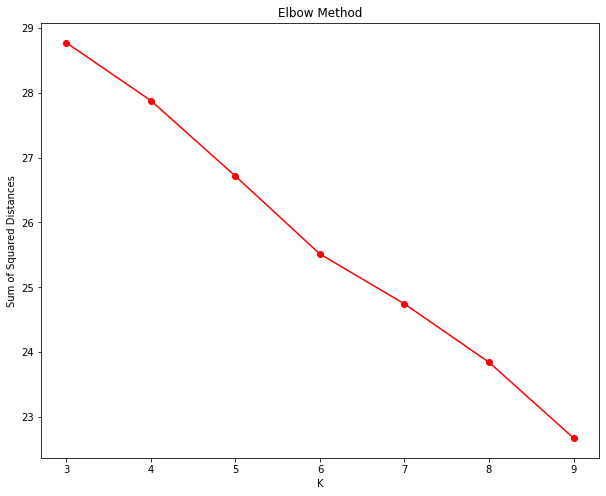

In [35]:
# Plot to find the 'elbow' k value
plt.figure(figsize=(10, 8))
plt.plot(k_range, sum_of_squared_distances, 'ro-')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

Since a sharp elbow cannot be observed from the plot, the best K in this case is the median, 6. 

#### K-Means Clustering

We then run <code>sklearn.cluster.KMeans</code> to cluster the neighborhood into 6 clusters.

In [36]:
# Fit the model with best K value
kmeans_model_best = KMeans(n_clusters=6, random_state=0).fit(df_feed_kmeans)
kmeans_model_best.labels_[:10]

array([1, 1, 0, 1, 1, 1, 3, 5, 2, 1], dtype=int32)

Insert the cluster labels to the <code>df_top_venues</code> dataframe:

In [37]:
df_top_venues.insert(1, 'cluster_labels', kmeans_model_best.labels_)
df_top_venues.head()

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,1,Asian Restaurant,Frozen Yogurt Shop,Snack Place,Night Market,Indian Restaurant,Breakfast Spot,Fast Food Restaurant,Bakery,Café,Coffee Shop
1,Aljunied,1,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market
2,Ang Mo Kio,0,Fast Food Restaurant,Food Court,Sushi Restaurant,Convenience Store,Pharmacy,Snack Place,Yoga Studio,Food Truck,Food & Drink Shop,Flower Shop
3,Bartley,1,Soccer Field,Concert Hall,Yoga Studio,Fast Food Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
4,Beauty World,1,Korean Restaurant,Fast Food Restaurant,Café,Supermarket,Noodle House,Bakery,Dessert Shop,Pizza Place,Electronics Store,Farmers Market


We add back each station's coordinates for later visualization:

In [38]:
add_back_df = df[['station_name', 'lat', 'lng']]
df_top_venues = df_top_venues.merge(add_back_df, how='inner', on='station_name')
rearrange_columns = list(df_top_venues.columns[-2:]) + list(df_top_venues.columns[:-2])
df_top_venues = df_top_venues[rearrange_columns]
df_top_venues.head()

,lat,lng,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1.436984,103.786406,Admiralty,1,Asian Restaurant,Frozen Yogurt Shop,Snack Place,Night Market,Indian Restaurant,Breakfast Spot,Fast Food Restaurant,Bakery,Café,Coffee Shop
1,1.316474,103.882762,Aljunied,1,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market
2,1.370025,103.849588,Ang Mo Kio,0,Fast Food Restaurant,Food Court,Sushi Restaurant,Convenience Store,Pharmacy,Snack Place,Yoga Studio,Food Truck,Food & Drink Shop,Flower Shop
3,1.342923,103.879660,Bartley,1,Soccer Field,Concert Hall,Yoga Studio,Fast Food Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
4,1.341607,103.775682,Beauty World,1,Korean Restaurant,Fast Food Restaurant,Café,Supermarket,Noodle House,Bakery,Dessert Shop,Pizza Place,Electronics Store,Farmers Market


#### Visualization

We plot the clusters on a map:

In [39]:
sg_map_clusters = folium.Map(location=[sg_latitude, sg_longitude], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lng, name, cluster in zip(df_top_venues['lat'], df_top_venues['lng'], df_top_venues['station_name'], df_top_venues['cluster_labels']):
    label = folium.Popup(str(name) + '; Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(sg_map_clusters)
       
sg_map_clusters

N.B.: The map might **NOT** be visible on Github, but the code block for map plotting is correct and can be run in Skills Network Labs or in IBM Cloud Pak for Data.

<hr>

<a id="ref5"></a>
## Results

We try to examine each cluster and determine the discriminating venue categories that distinguish each cluster.

**Cluster 1**

In [40]:
df_top_venues.loc[df_top_venues['cluster_labels'] == 0, df_top_venues.columns[2:]]

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ang Mo Kio,0,Fast Food Restaurant,Food Court,Sushi Restaurant,Convenience Store,Pharmacy,Snack Place,Yoga Studio,Food Truck,Food & Drink Shop,Flower Shop
15,Buangkok,0,Fast Food Restaurant,Seafood Restaurant,Grocery Store,Yoga Studio,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
17,Bukit Batok,0,Fast Food Restaurant,Mobile Phone Shop,Sandwich Place,Yoga Studio,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
25,Choa Chu Kang,0,Fast Food Restaurant,Playground,Bakery,Café,Noodle House,Coffee Shop,Thai Restaurant,Sandwich Place,Asian Restaurant,Electronics Store
37,Fajar,0,Fast Food Restaurant,Supermarket,Food Court,Coffee Shop,Yoga Studio,French Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
48,Joo Koon,0,Fast Food Restaurant,Italian Restaurant,Convenience Store,Sporting Goods Shop,Snack Place,Shopping Mall,Chinese Restaurant,Coffee Shop,Bakery,Warehouse Store
52,Keat Hong,0,Fast Food Restaurant,Ice Cream Shop,Yoga Studio,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
62,Lavender,0,Bakery,Fast Food Restaurant,Hotel,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
70,Mattar,0,Shopping Mall,Yoga Studio,Fast Food Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market
77,Oasis,0,Fast Food Restaurant,Café,Coffee Shop,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop


**Cluster 2**

In [41]:
df_top_venues.loc[df_top_venues['cluster_labels'] == 1, df_top_venues.columns[2:]]

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,1,Asian Restaurant,Frozen Yogurt Shop,Snack Place,Night Market,Indian Restaurant,Breakfast Spot,Fast Food Restaurant,Bakery,Café,Coffee Shop
1,Aljunied,1,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market,Farmers Market
3,Bartley,1,Soccer Field,Concert Hall,Yoga Studio,Fast Food Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
4,Beauty World,1,Korean Restaurant,Fast Food Restaurant,Café,Supermarket,Noodle House,Bakery,Dessert Shop,Pizza Place,Electronics Store,Farmers Market
5,Bedok,1,Sushi Restaurant,Noodle House,Japanese Restaurant,American Restaurant,Frozen Yogurt Shop,Chinese Restaurant,Café,Bakery,Food Court,Fried Chicken Joint
9,Bishan,1,Café,Bubble Tea Shop,Japanese Restaurant,Ice Cream Shop,Fried Chicken Joint,Multiplex,Shopping Mall,Clothing Store,Bookstore,Coffee Shop
11,Boon Lay,1,Asian Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,American Restaurant,Gift Shop,Dessert Shop,Cosmetics Shop,Fast Food Restaurant,Seafood Restaurant
12,Botanic Gardens,1,Bakery,Italian Restaurant,Monument / Landmark,Supermarket,Shopping Mall,Gastropub,Burger Joint,Restaurant,Cupcake Shop,Dumpling Restaurant
13,Braddell,1,Bakery,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
14,Bras Basah,1,Japanese Restaurant,Café,Art Museum,Gastropub,Yoga Studio,Flea Market,French Restaurant,Food Truck,Food Court,Food & Drink Shop


**Cluster 3**

In [42]:
df_top_venues.loc[df_top_venues['cluster_labels'] == 2, df_top_venues.columns[2:]]

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bencoolen,2,Hotel,Café,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
26,City Hall,2,Café,Shopping Mall,Yoga Studio,Dessert Shop,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
42,Geylang Bahru,2,Café,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant
103,Sixth Avenue,2,Café,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant


**Cluster 4**

In [43]:
df_top_venues.loc[df_top_venues['cluster_labels'] == 3, df_top_venues.columns[2:]]

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Bedok North,3,Chinese Restaurant,Playground,Soccer Field,Yoga Studio,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
10,Boon Keng,3,Fried Chicken Joint,Convenience Store,Chinese Restaurant,Yoga Studio,Flea Market,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
23,Chinatown,3,Department Store,Dongbei Restaurant,Hostel,BBQ Joint,Chinese Restaurant,Yoga Studio,Flower Shop,Fried Chicken Joint,French Restaurant,Food Truck
40,Farrer Road,3,Chinese Restaurant,Bed & Breakfast,Yoga Studio,Fruit & Vegetable Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
50,Kadaloor,3,Chinese Restaurant,BBQ Joint,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
66,Marina Bay,3,Art Gallery,Chinese Restaurant,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
71,Meridian,3,Casino,Chinese Restaurant,Yoga Studio,Dim Sum Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop
79,Pasir Panjang,3,Seafood Restaurant,Café,Pizza Place,Food Court,Chinese Restaurant,Fast Food Restaurant,Food Truck,Food & Drink Shop,Flower Shop,Flea Market
94,Rochor,3,Chinese Restaurant,Yoga Studio,Flea Market,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Fast Food Restaurant
98,Segar,3,Supermarket,Yoga Studio,Fruit & Vegetable Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market


**Cluster 5**

In [44]:
df_top_venues.loc[df_top_venues['cluster_labels'] == 4, df_top_venues.columns[2:]]

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
84,Pioneer,4,Coffee Shop,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market
117,Thanggam,4,Coffee Shop,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market


**Cluster 6**

In [45]:
df_top_venues.loc[df_top_venues['cluster_labels'] == 5, df_top_venues.columns[2:]]

,station_name,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bedok Reservoir,5,Dance Studio,Yoga Studio,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Flower Shop,Flea Market


End